In [126]:
import numpy as np
import torch
import pickle
import itertools
import os
import random
import pandas as pd
from collections import Counter
import cv2
import re
from PIL import Image
from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, TensorDataset, DataLoader

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 1.9.1


In [141]:
BASE_DIR = "dataset/"
TEXT_DIR = BASE_DIR + "text_data/"
IMAGES_DIR = BASE_DIR + "images/all_items/"
SCENES_DIR = BASE_DIR + "images/room_scenes/"
POSITIVE_SIZE = None # We might only use a subset of the positive pairs
TRAIN_TEST_RATIO = 0.33

In [3]:
def preprocess_img(path):
  img = cv2.imread(path)
  img = cv2.resize(img, (256, 256))
  img = img.astype(np.float32) / 255
  return img

def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)

In [169]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(TEXT_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(TEXT_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(TEXT_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(TEXT_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(TEXT_DIR + "item_to_room.p")
item_to_rooms_map = {item_url.split("/")[-1].split(".jpg")[0] : val for item_url, val in item_to_rooms_map.items()}
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(TEXT_DIR + "room_to_items.p")

room_to_items = {}
unavailable_scenes = set()
for item_id, room_url_list in item_to_rooms_map.items():
    if not os.path.exists(IMAGES_DIR + item_id + ".jpg"):
        print(IMAGES_DIR + item_id + ".jpg" + " does not exist")
        continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        if not os.path.exists(BASE_DIR + room_url):
            if room_id not in unavailable_scenes:
                print(room_url + " does not exist")
                unavailable_scenes.add(room_id)

        if room_id not in room_to_items:
            room_to_items[room_id] = [item_id]
        else:
            room_to_items[room_id].append(item_id)

all_positive_pairs = []
for room, item_id_list in room_to_items.items():
    pairs_for_current_room = list(set([tuple(sorted(x)) for x in itertools.combinations(set(room_to_items[room]), 2)])) # n choose 2
    all_positive_pairs += pairs_for_current_room

images/room_scenes/ikea-a-colourful-room-for-kids-to-get-creative__1364308442737-s4.jpg does not exist
images/room_scenes/ikea-artist-studio-by-day-cosy-cocoon-by-night-1364319298711.jpg does not exist
images/room_scenes/ikea-snuggle-down-low-or-sleep-up-high-1364315930147.jpg does not exist
images/room_scenes/ikea-quiet-dolls-dinner-party-in-progress-1364315931914.jpg does not exist
images/room_scenes/ikea-how-to-sleep-and-surf-in-four-square-metres__1364315935574-s4.jpg does not exist
images/room_scenes/ikea-how-to-sleep-and-surf-in-four-square-metres-1364315936265.jpg does not exist
images/room_scenes/ikea-a-colourful-room-for-kids-to-get-creative-1364308442710.jpg does not exist
images/room_scenes/ikea-make-a-perfectly-pink-childrens-room-1364308437557.jpg does not exist
images/room_scenes/ikea-sturdy-space-saving-bunk-bed-for-tired-teammates__1364309506738-s4.jpg does not exist
images/room_scenes/ikea-sturdy-space-saving-bunk-bed-for-tired-teammates-1364309506713.jpg does not exis

In [170]:
def random_negative_sampling(products, all_positive_pairs, weights=None, count=None, random_state=None):
    selected_negative_pairs = []
    if random_state is not None: random.seed(random_state)
    while len(selected_negative_pairs) < (count or len(all_positive_pairs)):
        if weights is None:
            random_pair = tuple(random.sample(products, 2))
        else:
            random_pair = tuple(np.random.choice(products, p=weights, size=2, replace=False))
        if random_pair in all_positive_pairs or tuple(reversed(random_pair)) in all_positive_pairs:
            continue
        else:
            selected_negative_pairs.append(random_pair)
    return selected_negative_pairs
  
    
# Train-val split that does not share products between training and validation sets.
def generate_product_limited_samples(products, all_positive_pairs, random_state=None):
    """
    Generates positive and negative examples for the given products using shared
    occurence in rooms to indicate whether two products are compatible.

    products: A sequence of product IDs; ALL positive and negative pairs must
        contain only these product IDs.
    all_positive_pairs: A set of product ID pairs that are positive.
    
    Returns: A tuple (x, y), where x is a sequence of product ID pairs and y is
        the array of [0, 1] labels indicating presence in all_positive_pairs.
    """
    product_set = set(products)
    pos_set = set(all_positive_pairs)
    within_positive_pairs = [p[:2] for p in sorted(all_positive_pairs, key=lambda x: tuple(x[:2])) if p[0] in product_set and p[1] in product_set]
    weight_dict = Counter([x for pair in within_positive_pairs for x in pair])
    weights = np.array([weight_dict[x] for x in products]).astype(float)
    weights /= weights.sum()
    
    negative_pairs = random_negative_sampling(products, pos_set, weights=weights, count=len(within_positive_pairs), random_state=random_state)
    x = within_positive_pairs + negative_pairs
    y = np.array([1] * len(within_positive_pairs) + [0] * len(negative_pairs))
    if random_state is not None: np.random.seed(random_state)
    indices = np.random.permutation(np.arange(len(x)))
    return [x[i] for i in indices], y[indices]

all_products = sorted(set([x for pair in all_positive_pairs for x in pair[:2]]))
train_products, val_products = train_test_split(all_products, test_size=TRAIN_TEST_RATIO, random_state=517)

# train_pairs, y_train = generate_product_limited_samples(train_products, all_positive_pairs, random_state=517)
# val_pairs, y_val = generate_product_limited_samples(val_products, all_positive_pairs, random_state=517)
# print(len(train_pairs), len(val_pairs))

# with open(BASE_DIR + "testing_train_data.pkl", "wb") as file:
#     pickle.dump((train_pairs, y_train), file)
# with open(BASE_DIR + "testing_val_data.pkl", "wb") as file:
#     pickle.dump((val_pairs, y_val), file)

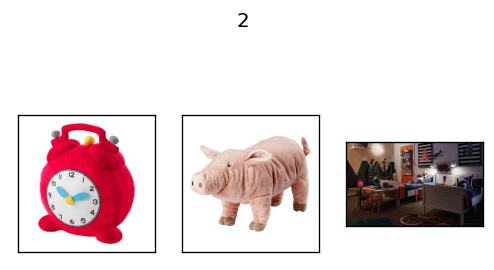

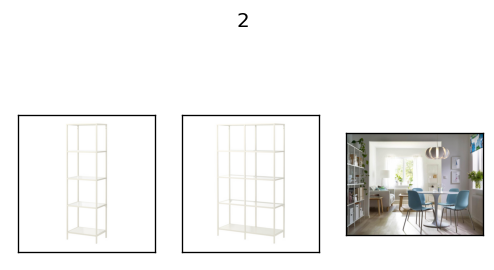

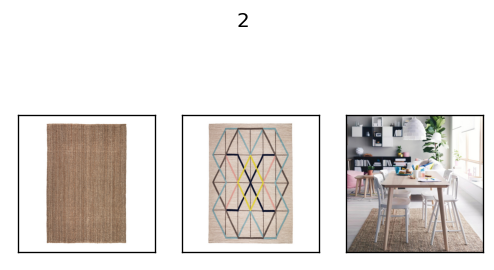

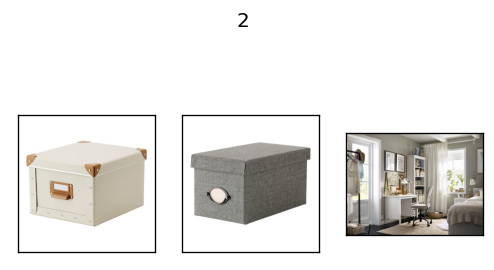

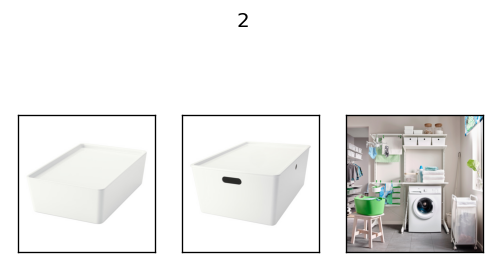

354 32573


In [161]:
num = 0
for item_1, item_2, scene in all_positive_pairs:
    type_1 = item_property[item_1]['type']
    type_2 = item_property[item_2]['type']
    if type_1 == type_2:
        num += 1
        if np.random.uniform() < 0.01:
            plt.figure(figsize=(5, 3), dpi=120)
            plt.subplot(131)
            plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_1 + ".jpg")))
            plt.xticks([])
            plt.yticks([])
            plt.subplot(132)
            plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_2 + ".jpg")))
            plt.xticks([])
            plt.yticks([])
            plt.subplot(133)
            if scene is not None:
                plt.imshow(Image.open(os.path.join(SCENES_DIR, scene + ".jpg")))
                plt.xticks([])
                plt.yticks([])
            plt.suptitle(count)
            plt.show()
print(num, len(all_positive_pairs))

So clearly some products have the same name, but they're still worth including in the dataset as compatible.

# Weighting (ultimately not used)

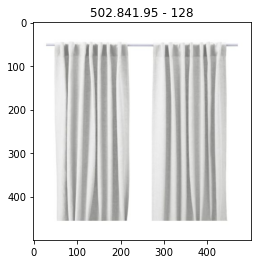

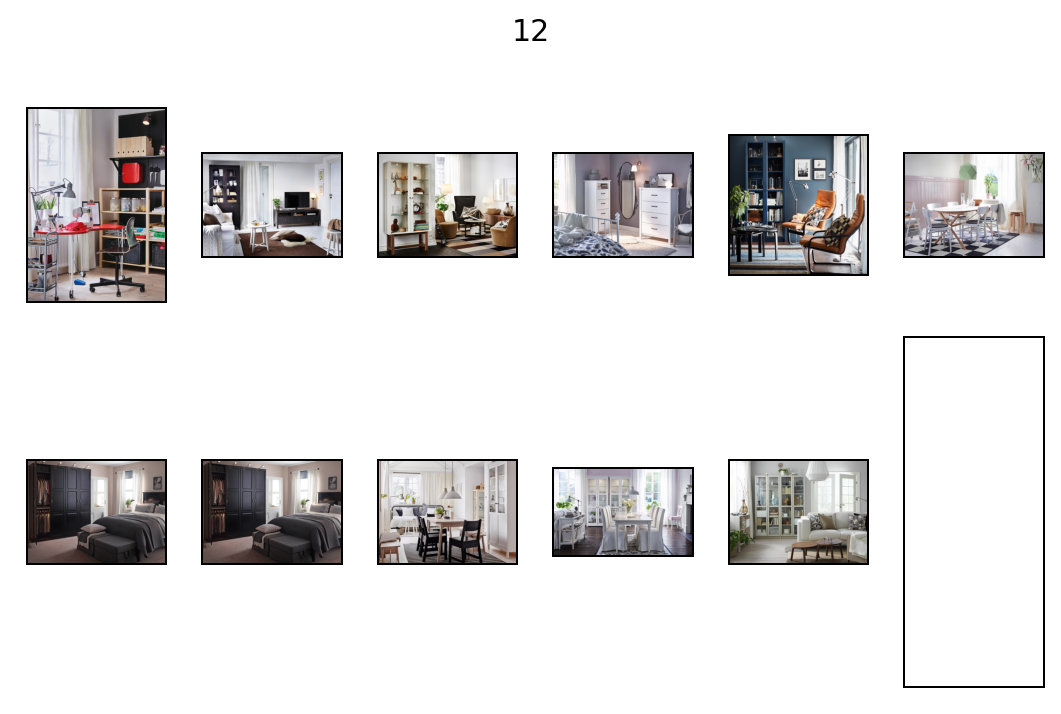

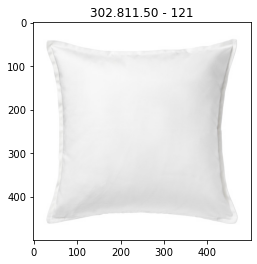

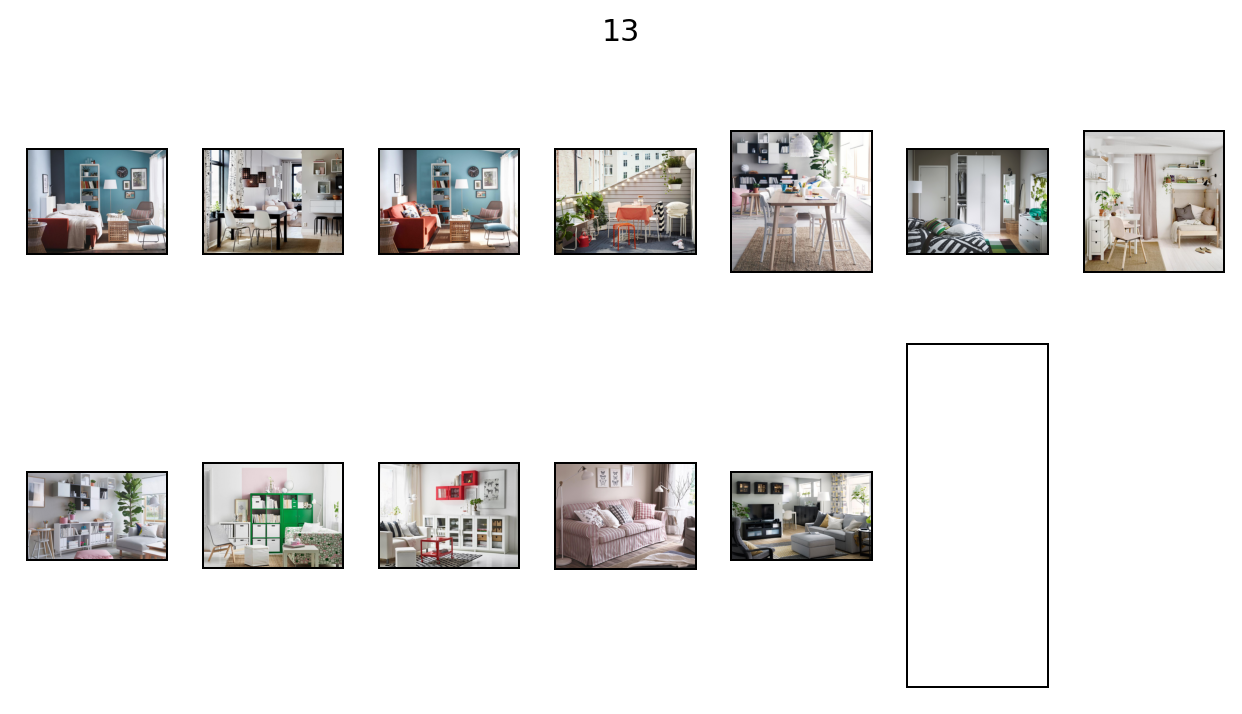

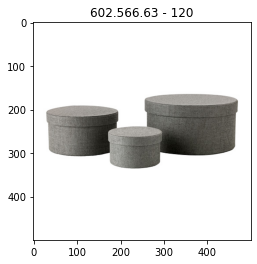

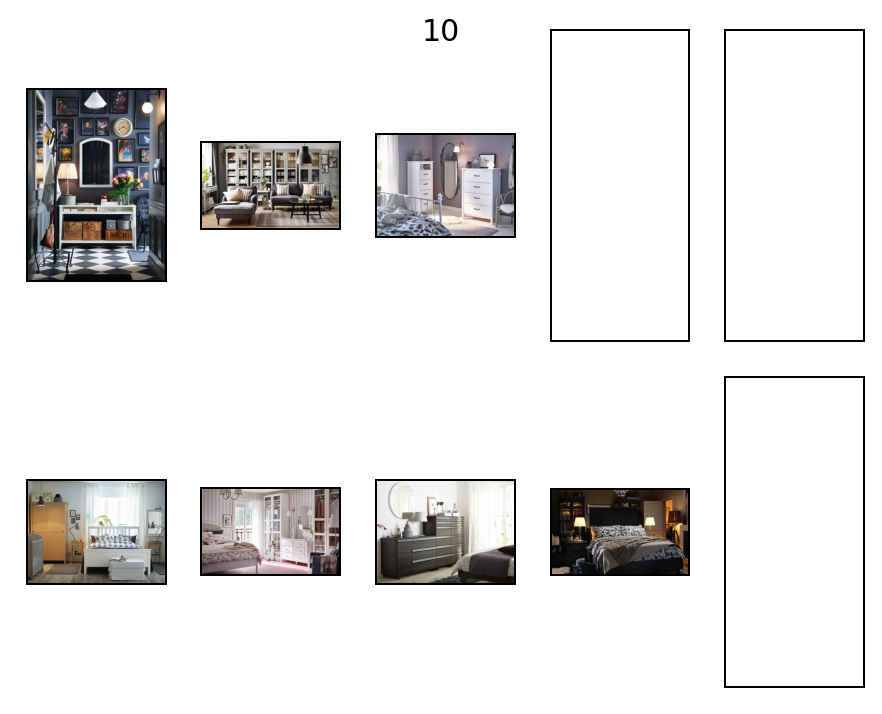

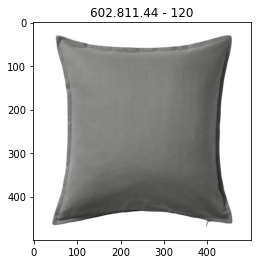

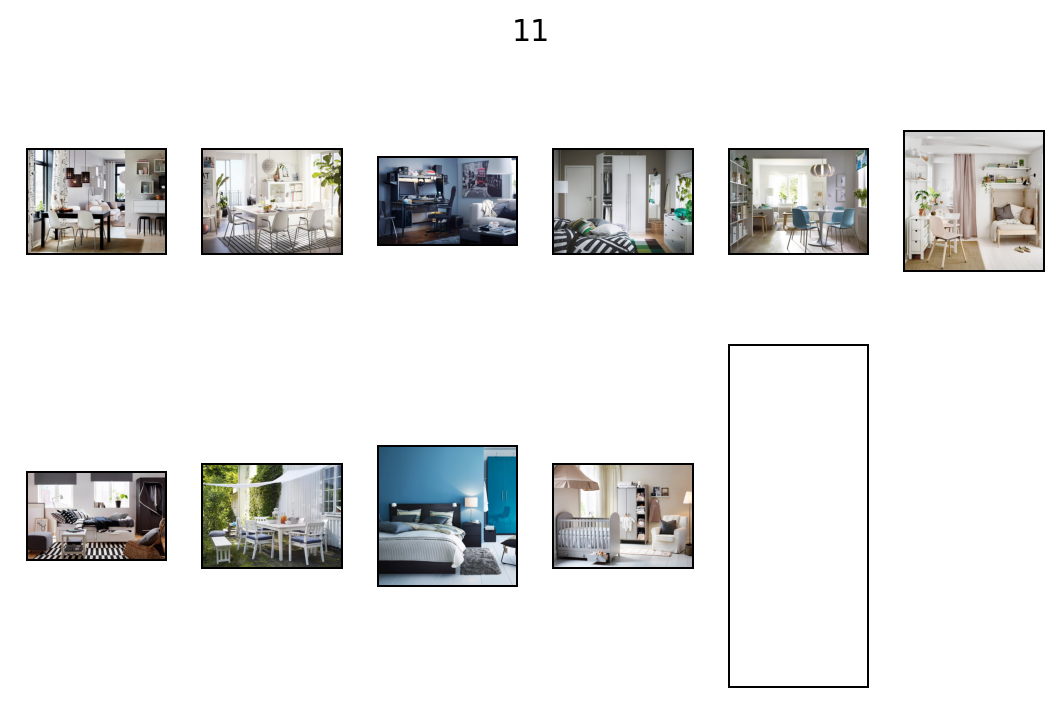

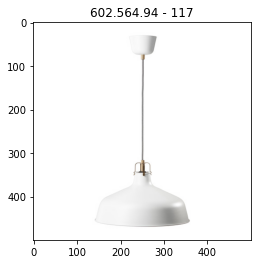

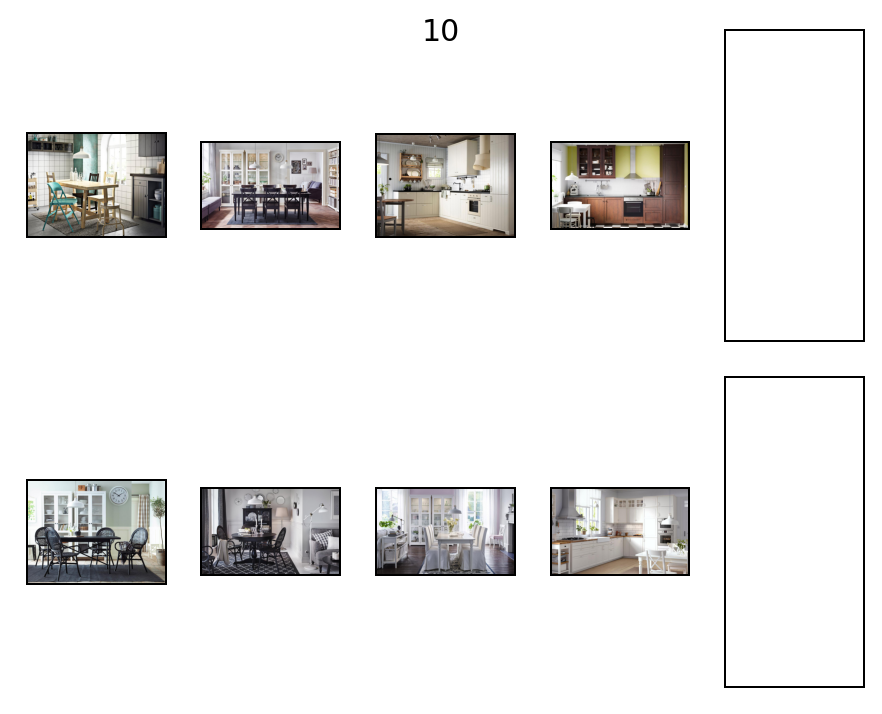

In [22]:
# Let's find out which products occur in a lot of rooms
from collections import Counter

counts = Counter([x for pair in all_positive_pairs for x in pair])

for item_id, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[5:10]:
    plt.figure()
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_id + ".jpg")))
    plt.title(item_id + " - " + str(count))
    plt.show()
    rooms = item_to_rooms_map[item_id]
    plt.figure(figsize=(int(np.ceil(len(rooms) / 2)), 4), dpi=180)
    for i, img_url in enumerate(rooms):
        plt.subplot(2, int(np.ceil(len(rooms) / 2)), i + 1)
        path = os.path.join(BASE_DIR, img_url)
        if os.path.exists(path):
            plt.imshow(Image.open(path))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.suptitle(len(rooms))
    plt.show()

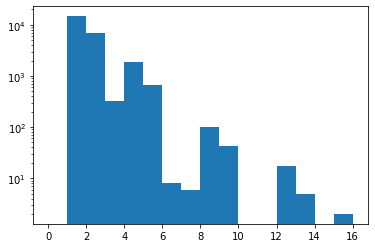

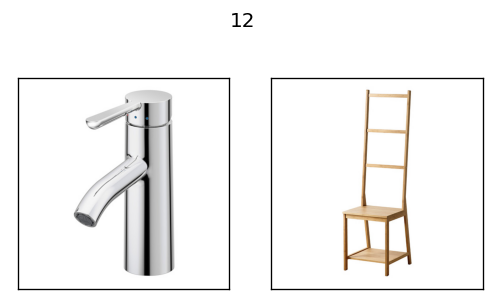

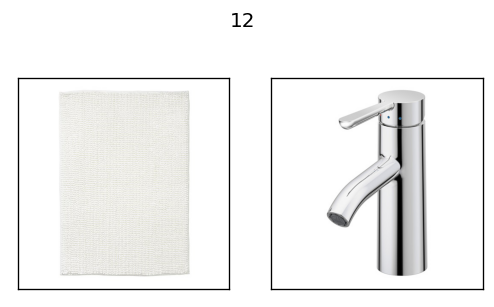

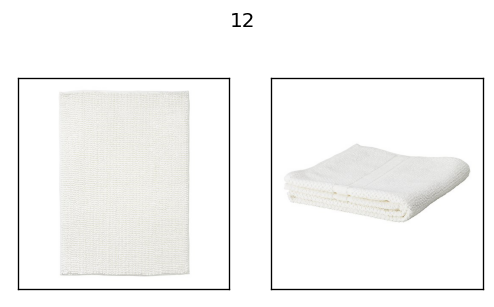

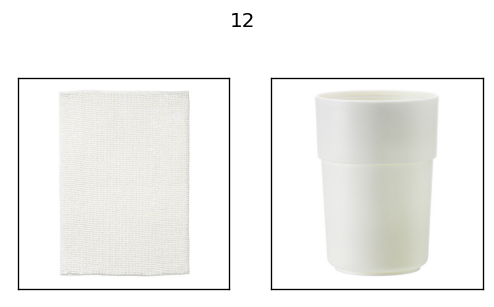

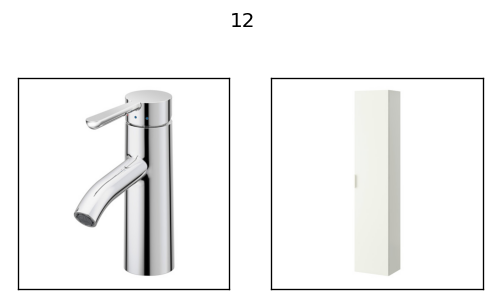

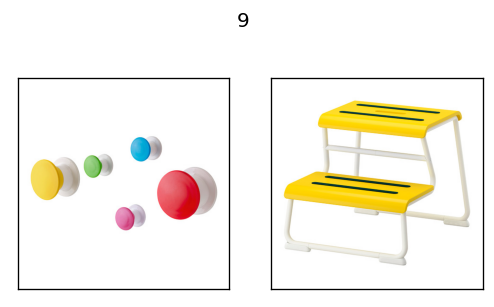

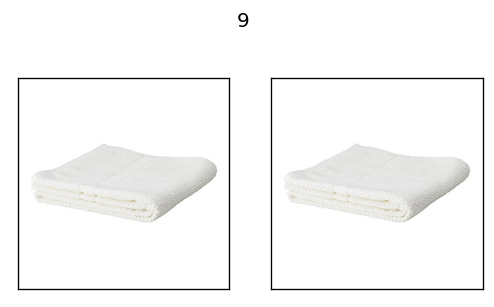

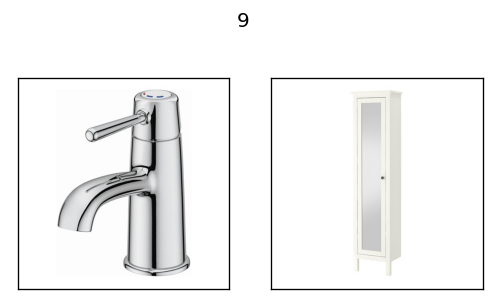

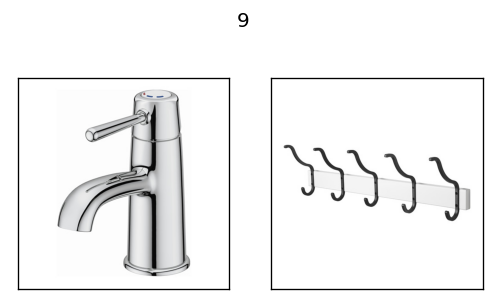

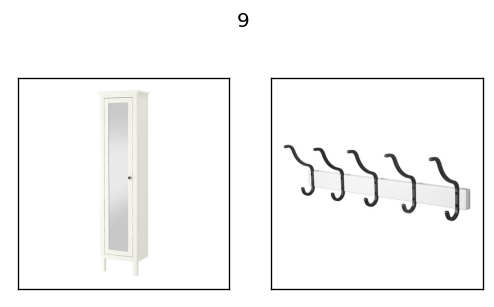

In [ ]:
# Find pairs that co-occur in a lot of rooms

pos_pairs = []
for room, item_id_list in room_to_items.items():
    pairs_for_current_room = list(itertools.combinations(room_to_items[room], 2)) # n choose 2
    pos_pairs += pairs_for_current_room
pair_counts = Counter(pos_pairs)

plt.figure()
plt.hist(pair_counts.values(), bins=np.arange(max(pair_counts.values())))
plt.semilogy()
plt.show()
for (item_1, item_2), count in sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[20:30]:
    plt.figure(figsize=(5, 3), dpi=120)
    plt.subplot(121)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_1 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_2 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.suptitle(count)
    plt.show()

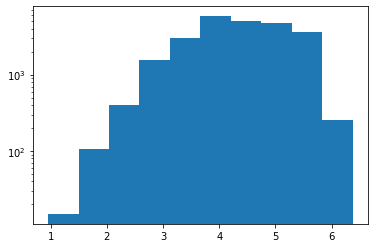

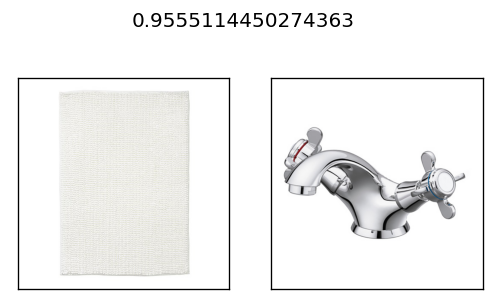

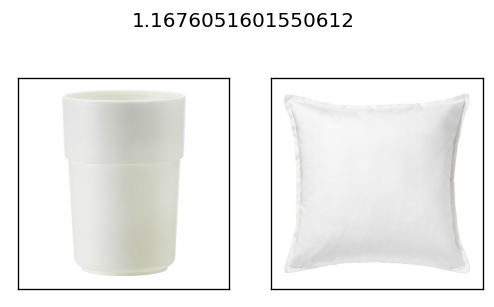

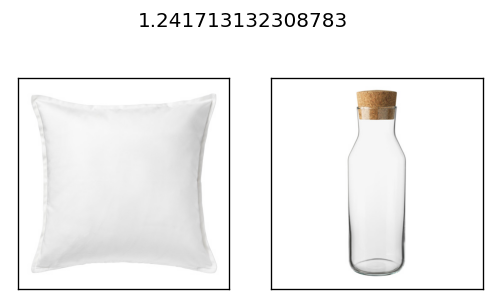

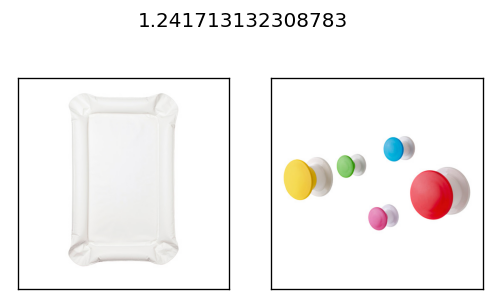

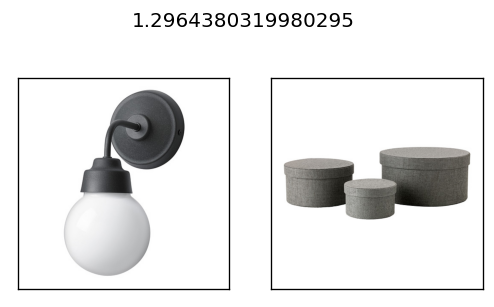

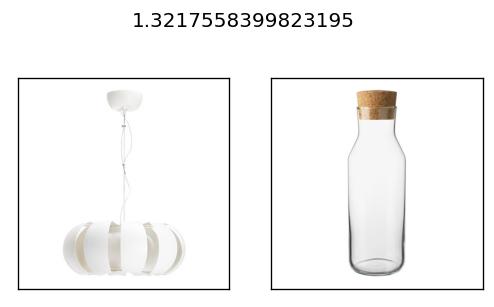

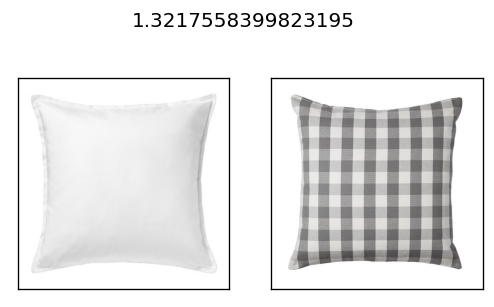

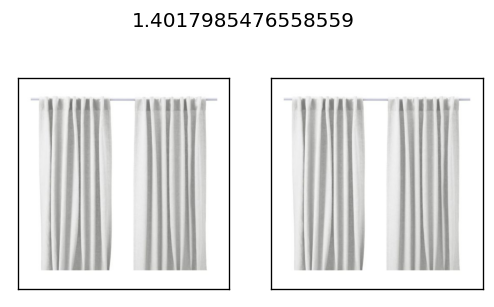

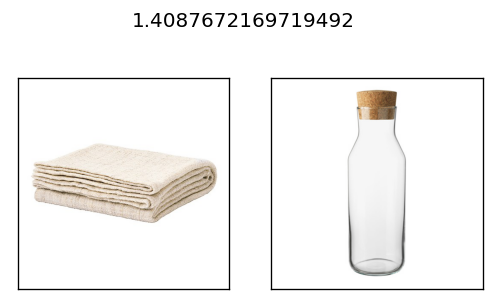

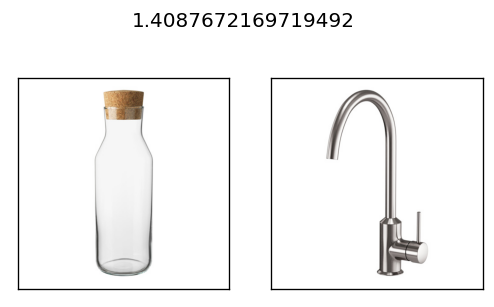

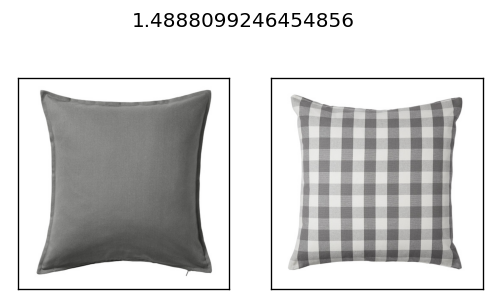

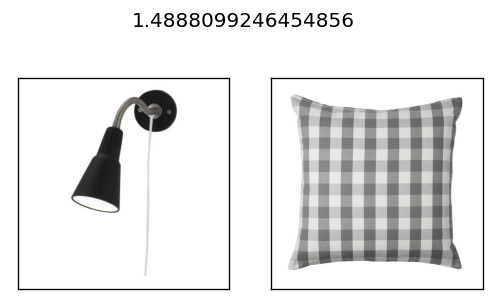

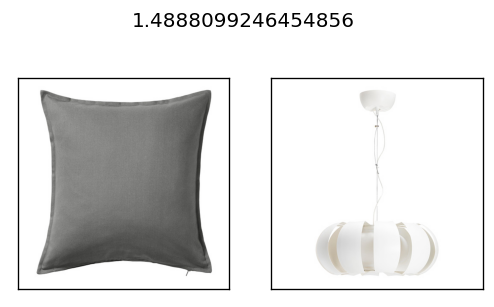

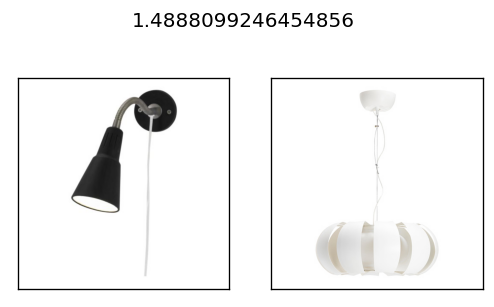

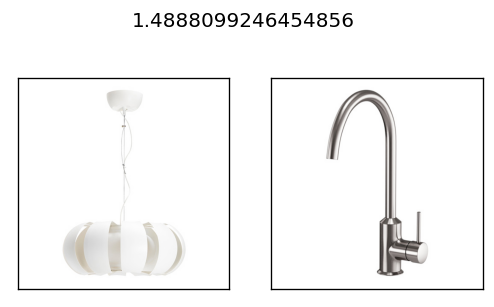

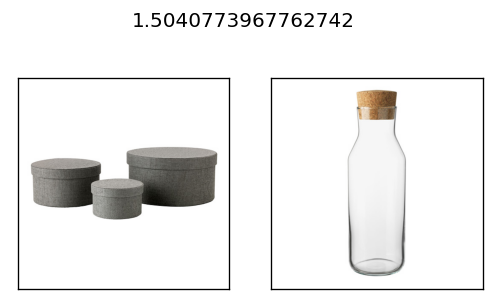

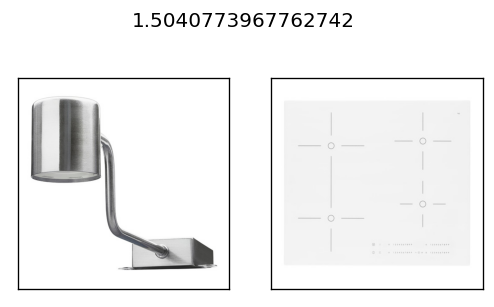

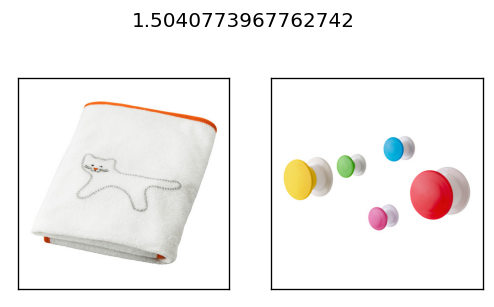

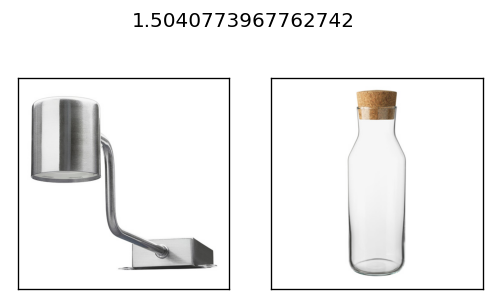

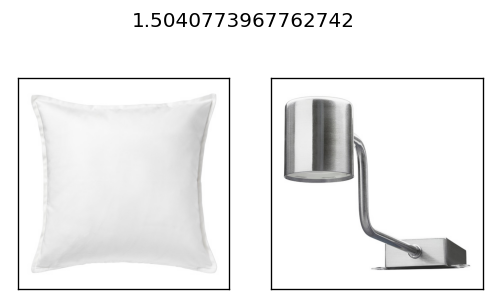

In [36]:
# Now let's try reweighting the positive examples. One strategy is Pointwise Mutual Information:

weights = {(item_1, item_2): np.log((pair_counts[(item_1, item_2)] / len(room_to_items)) /
                                    (len(item_to_rooms_map[item_1]) * len(item_to_rooms_map[item_2]) / (len(room_to_items) ** 2)))
           for item_1, item_2 in all_positive_pairs}
plt.figure()
plt.hist(weights.values())
plt.semilogy()
plt.show()
for (item_1, item_2), weight in sorted(weights.items(), key=lambda x: x[1])[:20]:
    plt.figure(figsize=(5, 3), dpi=120)
    plt.subplot(121)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_1 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_2 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.suptitle(weight)
    plt.show()

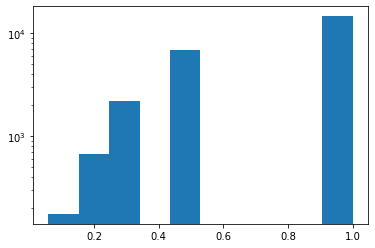

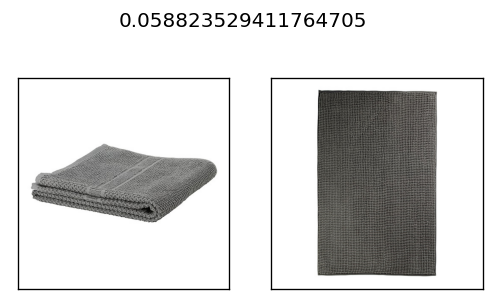

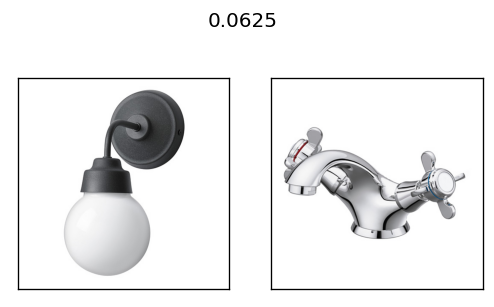

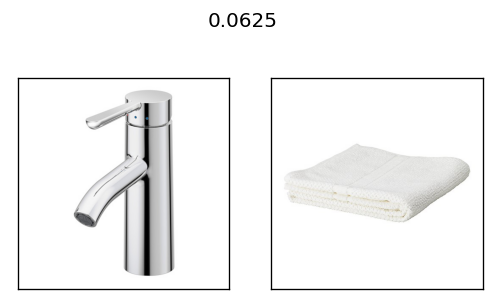

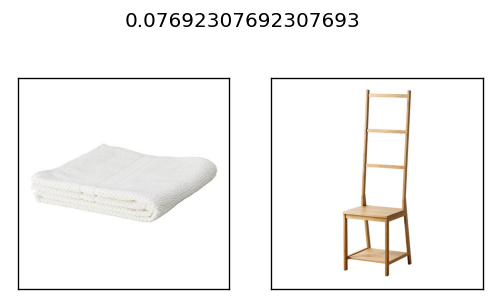

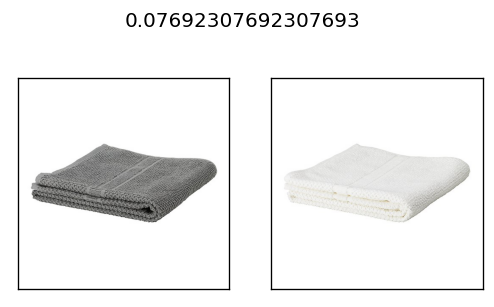

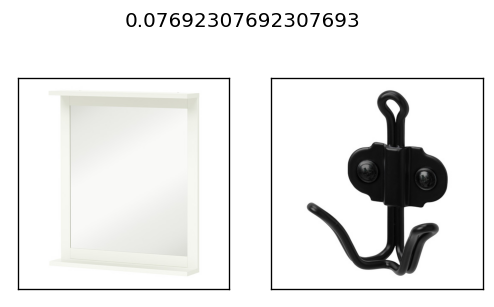

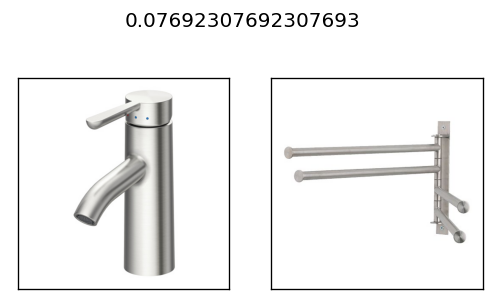

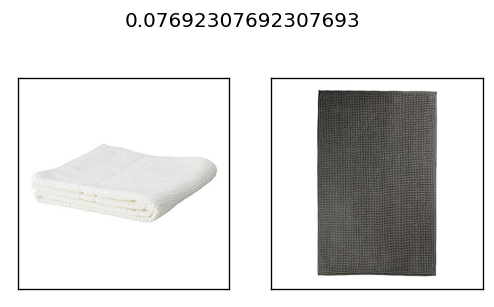

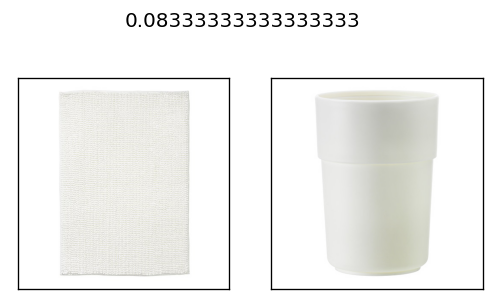

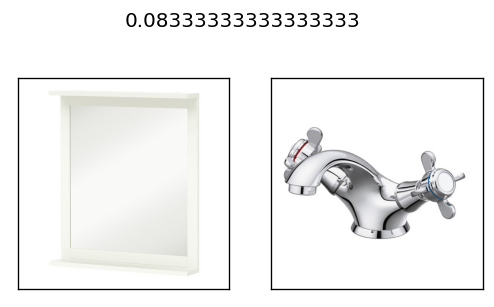

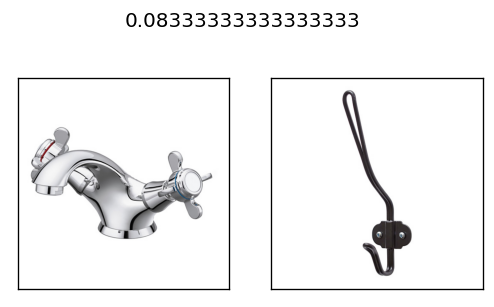

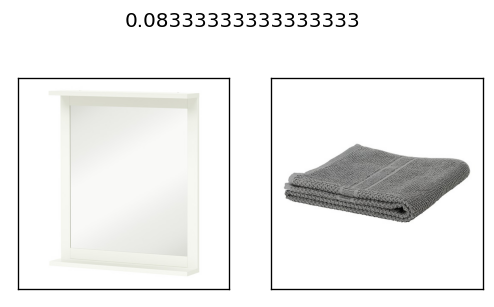

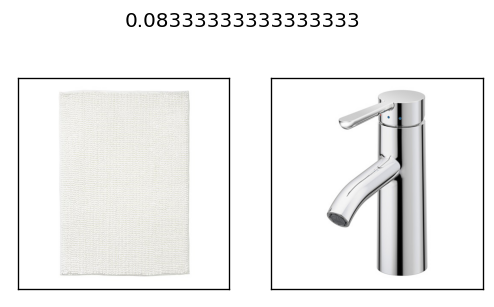

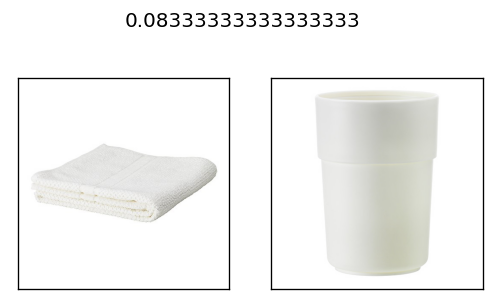

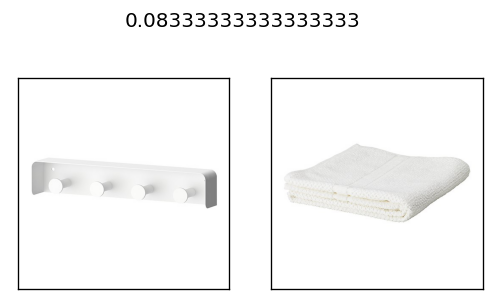

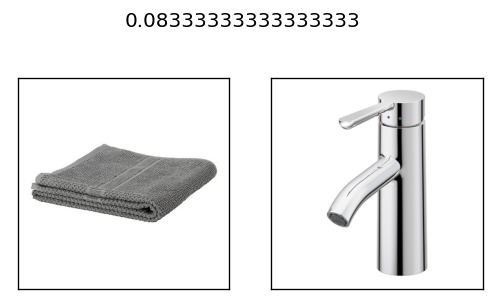

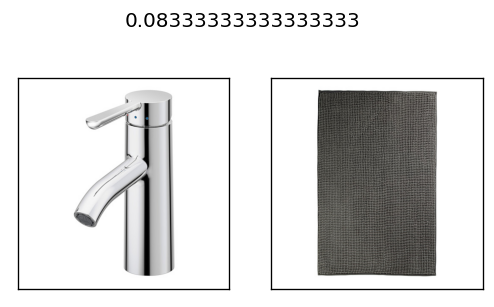

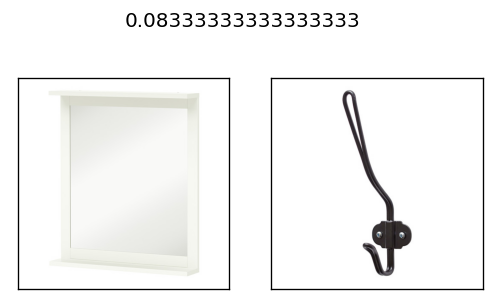

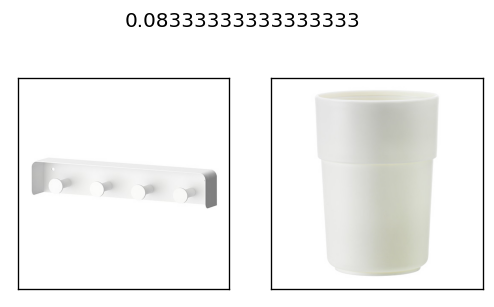

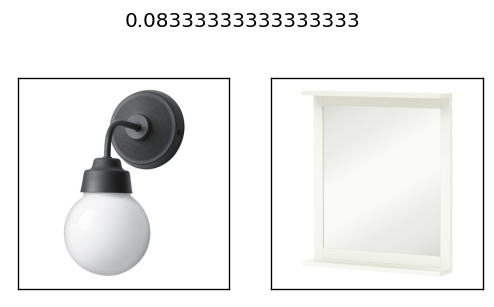

In [34]:
# Another strategy is simply to divide the estimated compatibility by the number of co-occurrences

weights = {(item_1, item_2): 1 / pair_counts[(item_1, item_2)]
           for item_1, item_2 in all_positive_pairs}
plt.figure()
plt.hist(weights.values())
plt.semilogy()
plt.show()
for (item_1, item_2), weight in sorted(weights.items(), key=lambda x: x[1])[:20]:
    plt.figure(figsize=(5, 3), dpi=120)
    plt.subplot(121)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_1 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_2 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.suptitle(weight)
    plt.show()

# Training Set Generation (PU Bagging)

In [171]:
# PU bagging - generate k datasets with negative sampling in each one

NUM_BAGS = 10
BAG_SEEDS = [5647 * k for k in range(NUM_BAGS)]

train_sets = []
for k, seed in tqdm.tqdm(enumerate(BAG_SEEDS), total=NUM_BAGS):
    train_sets.append(generate_product_limited_samples(train_products, all_positive_pairs, random_state=seed))
    
val_pairs, y_val = generate_product_limited_samples(val_products, all_positive_pairs, random_state=517)
print(len(train_sets), len(train_sets[0][0]), len(val_pairs))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:48<00:00,  4.86s/it]


10 29382 6950


In [180]:
# Generate room IDs for each training pair
def get_room_id(pair, label):
    """Gets a room ID (with an available image) for the given pair, or None if no
    image is available. If the products are not co-occurring, returns a random room ID
    containing one of the products or None with the same frequency."""
    rooms_1 = set(item_to_rooms_map[pair[0]])
    rooms_2 = set(item_to_rooms_map[pair[1]])
    if label:
        assert len(rooms_1 & rooms_2) > 0, "pair with positive label doesn't co-occur in any rooms"
        room_url = np.random.choice(list(rooms_1 & rooms_2))
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        return room_id if os.path.exists(BASE_DIR + room_url) else None
    else:
        assert len(rooms_1 & rooms_2) == 0, "pair with negative label ({}, {}) co-occurs in one or more rooms: {}".format(*pair, rooms_1 & rooms_2)
        room_url = np.random.choice(list(rooms_1 | rooms_2))
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        return room_id if os.path.exists(BASE_DIR + room_url) else None

train_sets_with_rooms = []
for train_pairs, labels in train_sets:
    room_ids = [get_room_id(pair, label) for pair, label in zip(train_pairs, labels)]
    train_sets_with_rooms.append((train_pairs, labels, room_ids))
    print("{:.3f} of positive pairs and {:.3f} of negative pairs have None".format(np.mean([not r for r, l in zip(room_ids, labels) if l]),
                                                                                   np.mean([not r for r, l in zip(room_ids, labels) if not l]), len(room_ids)))

0.440 of positive pairs and 0.491 of negative pairs have None
0.437 of positive pairs and 0.497 of negative pairs have None
0.441 of positive pairs and 0.499 of negative pairs have None
0.441 of positive pairs and 0.497 of negative pairs have None
0.439 of positive pairs and 0.499 of negative pairs have None
0.437 of positive pairs and 0.495 of negative pairs have None
0.436 of positive pairs and 0.495 of negative pairs have None
0.443 of positive pairs and 0.498 of negative pairs have None
0.441 of positive pairs and 0.496 of negative pairs have None
0.439 of positive pairs and 0.500 of negative pairs have None


In [177]:
room_to_items['ikea-easy-install-mini-kitchen-on-a-shoestring__1364315999587-s4']

['901.840.47',
 '601.109.01',
 '301.805.04',
 '902.648.88',
 '003.053.79',
 '001.258.11',
 '100.989.87',
 '403.702.83',
 '603.122.49',
 '900.850.28',
 '703.037.20',
 '903.020.79',
 '903.316.75',
 '503.037.35',
 '403.316.30',
 '999.037.88',
 '891.872.40',
 '002.886.81']

In [118]:
sorted(Counter(train_sets[0][0]).items(), key=lambda x: x[1], reverse=True)[:10]

[(('402.913.42', '803.039.32'), 6),
 (('501.591.77', '502.213.01'), 5),
 (('402.913.42', '603.009.01'), 5),
 (('302.567.25', '902.696.97'), 5),
 (('301.992.83', '502.517.98'), 5),
 (('002.813.02', '600.478.96'), 4),
 (('402.595.11', '802.671.37'), 4),
 (('301.591.83', '602.812.95'), 4),
 (('401.315.51', '702.334.21'), 4),
 (('303.197.23', '303.208.54'), 4)]

In [105]:
for i, (pair, label) in enumerate(zip(*train_sets[0])):
    if pair == ('402.913.42', '803.039.32'):
        print(pair, label)

('402.913.42', '803.039.32') 1
('402.913.42', '803.039.32') 1
('402.913.42', '803.039.32') 1
('402.913.42', '803.039.32') 1
('402.913.42', '803.039.32') 1
('402.913.42', '803.039.32') 1


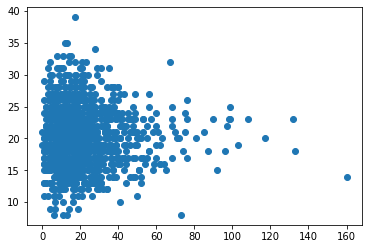

In [109]:
# Determine what the counts of each product are in positive and negative classes
pos_counts = Counter([x for pair, label in zip(*train_sets[0]) for x in pair if label])
neg_counts = Counter([x for pair, label in zip(*train_sets[0]) for x in pair if not label])
plt.scatter([pos_counts[x] for x in train_products], [neg_counts[x] for x in train_products])

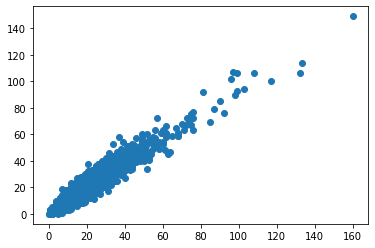

In [119]:
pos_counts = Counter([x for pair, label in zip(*train_sets[0]) for x in pair if label])
neg_counts = Counter([x for pair, label in zip(*train_sets[0]) for x in pair if not label])
plt.scatter([pos_counts[x] for x in train_products], [neg_counts[x] for x in train_products])

2599 3414
=============POSITIVE


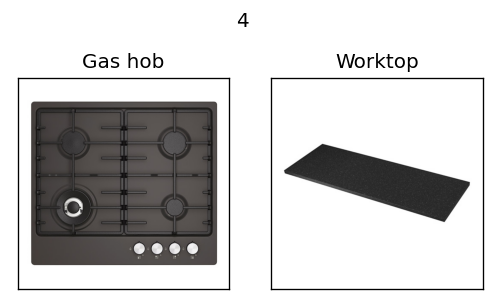

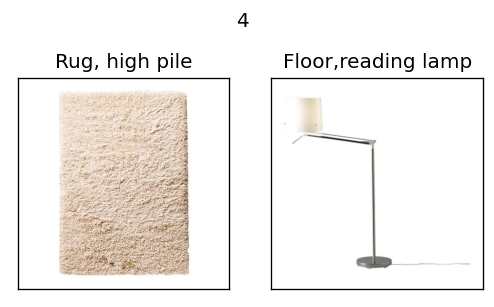

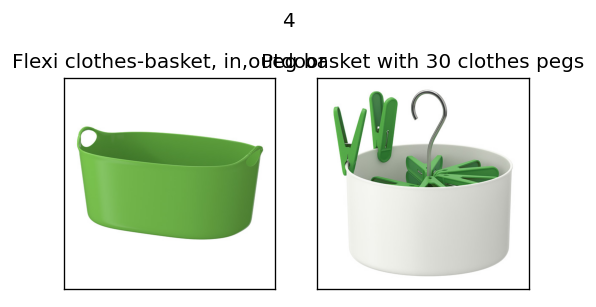

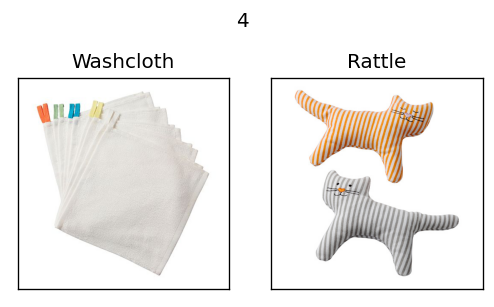

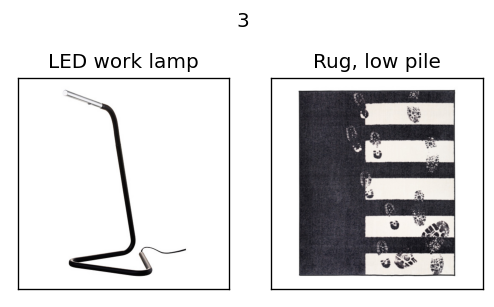

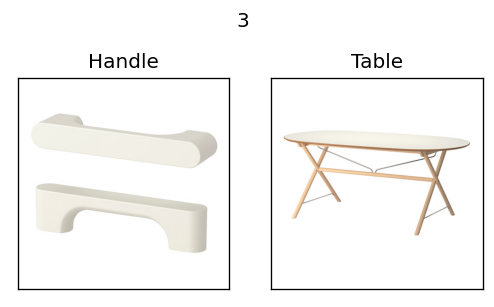

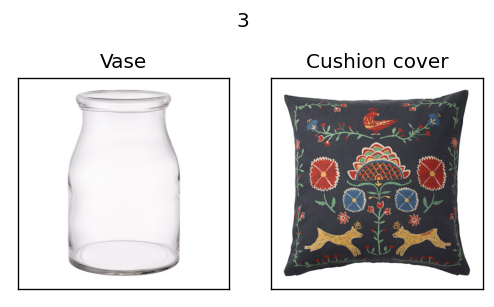

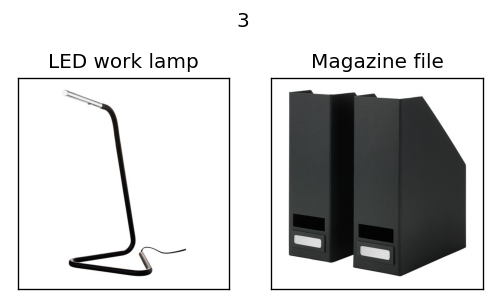

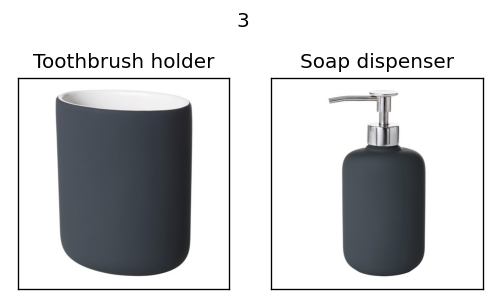

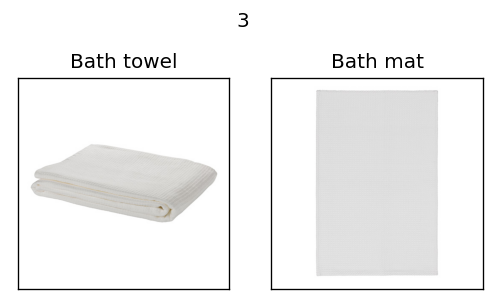

=============NEGATIVE


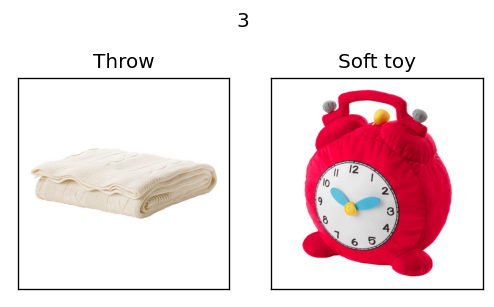

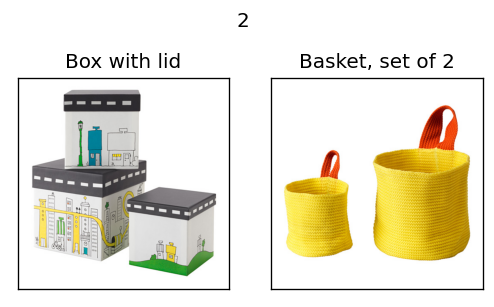

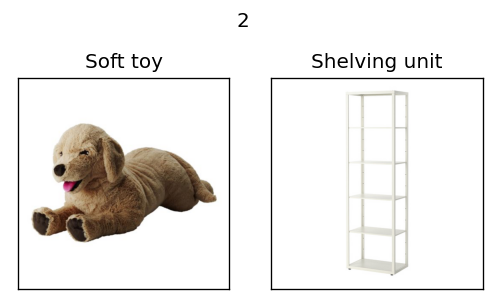

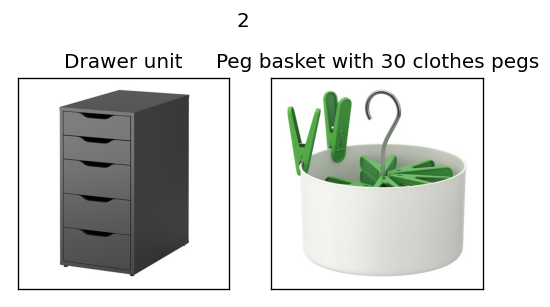

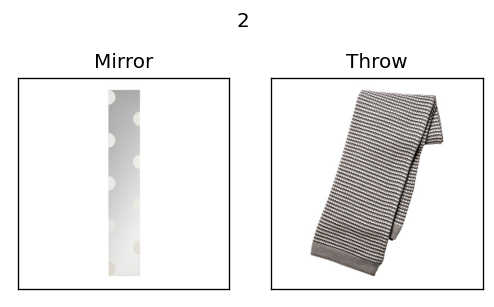

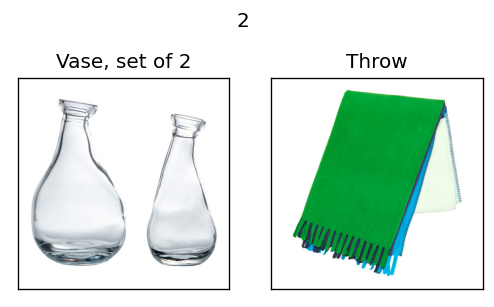

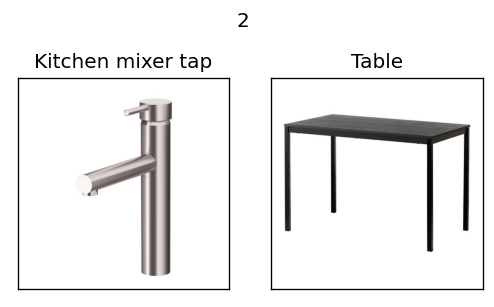

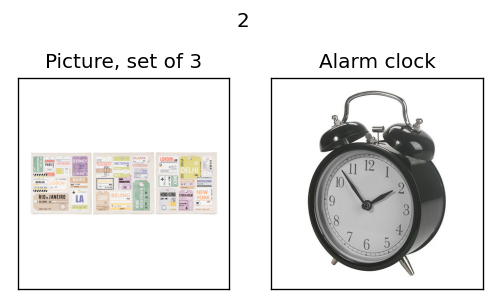

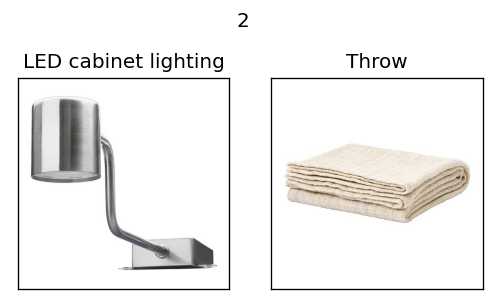

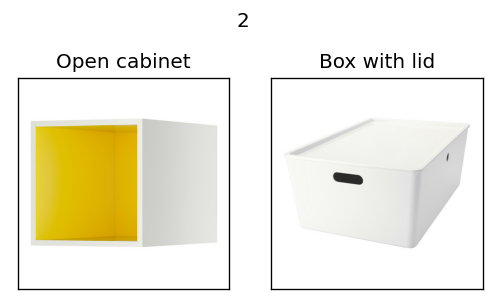

In [136]:
# What are the most frequent positive and negative pairs?
sorted_pos_pairs = []
sorted_neg_pairs = []
# for pairs, labels in train_sets:
for pair, label in zip(val_pairs, y_val): # zip(pairs, labels):
#         if not ('bed' in item_property[pair[0]]['type'].lower() or 'bed' in item_property[pair[1]]['type'].lower()):
#             continue
    if label:
        sorted_pos_pairs.append(tuple(sorted(pair)))
    else:
        sorted_neg_pairs.append(tuple(sorted(pair)))

sorted_pos_pairs = sorted(Counter(sorted_pos_pairs).items(), key=lambda x: x[1], reverse=True)
sorted_neg_pairs = sorted(Counter(sorted_neg_pairs).items(), key=lambda x: x[1], reverse=True)
print(len(sorted_pos_pairs), len(sorted_neg_pairs))

print("=============POSITIVE")
for (item_1, item_2), count in sorted_pos_pairs[:10]:
    plt.figure(figsize=(5, 3), dpi=120)
    plt.subplot(121)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_1 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.title(item_property[item_1]['type'])
    plt.subplot(122)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_2 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.title(item_property[item_2]['type'])
    plt.suptitle(count)
    plt.show()
print("=============NEGATIVE")
for (item_1, item_2), count in sorted_neg_pairs[:10]:
    plt.figure(figsize=(5, 3), dpi=120)
    plt.subplot(121)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_1 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.title(item_property[item_1]['type'])
    plt.subplot(122)
    plt.imshow(Image.open(os.path.join(IMAGES_DIR, item_2 + ".jpg")))
    plt.xticks([])
    plt.yticks([])
    plt.title(item_property[item_2]['type'])
    plt.suptitle(count)
    plt.show()

# Text Preprocessing

In [132]:
product_names = "(" + "|".join(list(set([value["name"] for value in item_property.values()]))) + ")"

def preprocess_info(properties):
    base = properties["type"] + " " + properties["desc"]
    base = base.replace("View more product information", "")
#     matches = re.findall(product_names, base)
#     if matches: print(matches)
    base = re.sub(product_names, '', base)
    return re.sub(r'\s+', ' ', base)

item_to_info = {key: preprocess_info(value) for key, value in item_property.items()} # remove view more info

# Writing Output

In [133]:
with open(os.path.join(BASE_DIR, "train_sets.pkl"), "wb") as file:
    pickle.dump(train_sets, file)
with open(os.path.join(BASE_DIR, "val_data.pkl"), "wb") as file:
    pickle.dump((val_pairs, y_val), file)
with open(os.path.join(BASE_DIR, "preprocessed_text.pkl"), "wb") as file:
    pickle.dump(item_to_info, file)